#  Physio-REFERS: Hybrid Vision Transformer with Anatomical Knowledge

## Architecture Overview
**Physio-REFERS** is a dual-stream architecture combining:
- **Visual Stream**: Vision Transformer (ViT-B/16) for texture/opacity analysis
- **Anatomical Stream**: Graph Neural Network for anatomical topology
- **Cross-Attention Fusion**: Intelligent integration of visual and anatomical features

---
##  Table of Contents
1. Environment Setup
2. Core Architecture Implementation
3. Training Pipeline
4. Evaluation & Visualization
5. Results Comparison

## 1️⃣ Environment Setup & Dependencies

In [ ]:
# Check GPU availability (important for Colab)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

🖥️ Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB


In [ ]:
# Install required packages
!pip install -q timm==0.9.12  # For Vision Transformer models
!pip install -q torch-geometric  # For Graph Neural Networks
!pip install -q scikit-learn matplotlib seaborn opencv-python pillow
!pip install -q grad-cam  # For attention visualization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import timm
from typing import Optional, Tuple, List
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# For Graph Neural Networks
try:
    from torch_geometric.nn import GCNConv, global_mean_pool
    from torch_geometric.data import Data, Batch
    GRAPH_AVAILABLE = True
except ImportError:
    print(" torch_geometric not fully installed. Using simplified graph implementation.")
    GRAPH_AVAILABLE = False

## 2️⃣ Core Architecture Implementation

### 2.1 Anatomical Landmark Detector

In [ ]:
class AnatomicalLandmarkDetector(nn.Module):
    """
    Detects 5 key anatomical landmarks in chest X-rays:
    - Left & Right Clavicle
    - Heart Center
    - Left & Right Apex (lung tops)
    - Left & Right Diaphragm

    For simplicity, we use a lightweight CNN-based detector.
    In production, you could use a pretrained keypoint detector.
    """
    def __init__(self, num_landmarks: int = 5):
        super().__init__()
        self.num_landmarks = num_landmarks

        # Simple CNN for landmark detection
        self.conv1 = nn.Conv2d(3, 32, 7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Output: (x, y) coordinates for each landmark
        self.fc = nn.Linear(128, num_landmarks * 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input images [B, 3, H, W]
        Returns:
            landmarks: [B, num_landmarks, 2] normalized (x, y) coordinates
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x).flatten(1)

        coords = self.fc(x)  # [B, num_landmarks*2]
        coords = torch.sigmoid(coords)  # Normalize to [0, 1]
        landmarks = coords.view(-1, self.num_landmarks, 2)  # [B, num_landmarks, 2]

        return landmarks

### 2.2 Anatomical Graph Neural Network

In [ ]:
class AnatomicalGNN(nn.Module):
    """
    Graph Neural Network modeling anatomical relationships.

    Graph Structure:
    - Nodes: 5 anatomical landmarks
    - Edges: Anatomical connections (e.g., clavicles connect to heart)
    """
    def __init__(self, node_features: int = 2, hidden_dim: int = 64, output_dim: int = 128):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        if GRAPH_AVAILABLE:
            # Using torch_geometric
            self.conv1 = GCNConv(node_features, hidden_dim)
            self.conv2 = GCNConv(hidden_dim, hidden_dim)
            self.conv3 = GCNConv(hidden_dim, output_dim)
        else:
            # Fallback: simple graph convolution with adjacency matrix
            self.fc1 = nn.Linear(node_features, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.use_torch_geometric = GRAPH_AVAILABLE

    def get_anatomical_edges(self, num_nodes: int = 5) -> torch.Tensor:
        """
        Define anatomical graph structure.
        Edge connections based on anatomical proximity.

        Nodes: [Left Clavicle, Right Clavicle, Heart, Left Apex, Right Apex]
        """
        # Edge list (undirected graph)
        edges = [
            (0, 2),  # Left clavicle - Heart
            (1, 2),  # Right clavicle - Heart
            (2, 3),  # Heart - Left apex
            (2, 4),  # Heart - Right apex
            (0, 3),  # Left clavicle - Left apex
            (1, 4),  # Right clavicle - Right apex
            (3, 4),  # Left apex - Right apex
        ]

        # Convert to bidirectional edge_index format
        edge_index = []
        for (i, j) in edges:
            edge_index.append([i, j])
            edge_index.append([j, i])  # Add reverse edge

        return torch.tensor(edge_index, dtype=torch.long).t()  # [2, num_edges]

    def forward(self, landmarks: torch.Tensor) -> torch.Tensor:
        """
        Args:
            landmarks: [B, num_nodes, 2] landmark coordinates
        Returns:
            graph_features: [B, output_dim] anatomical graph embedding
        """
        batch_size = landmarks.size(0)
        device = landmarks.device

        if self.use_torch_geometric:
            # Create batch of graphs
            edge_index = self.get_anatomical_edges().to(device)

            # Process each sample in batch
            graph_embeddings = []
            for i in range(batch_size):
                x = landmarks[i]  # [num_nodes, 2]

                # GNN forward pass
                x = F.relu(self.conv1(x, edge_index))
                x = F.relu(self.conv2(x, edge_index))
                x = self.conv3(x, edge_index)

                # Global pooling
                graph_emb = x.mean(dim=0)  # [output_dim]
                graph_embeddings.append(graph_emb)

            return torch.stack(graph_embeddings)  # [B, output_dim]

        else:
            # Simplified version: use mean aggregation
            x = landmarks  # [B, num_nodes, 2]
            x = F.relu(self.fc1(x))  # [B, num_nodes, hidden_dim]
            x = F.relu(self.fc2(x))  # [B, num_nodes, hidden_dim]
            x = self.fc3(x)  # [B, num_nodes, output_dim]

            # Global pooling
            graph_features = x.mean(dim=1)  # [B, output_dim]
            return graph_features

### 2.3 Cross-Attention Fusion Module

In [ ]:
class CrossAttentionFusion(nn.Module):
    """
    Cross-Attention mechanism to fuse visual and anatomical features.

    Visual tokens query the anatomical graph to validate spatial positions.
    """
    def __init__(self, visual_dim: int = 768, anatomical_dim: int = 128,
                 num_heads: int = 8, dropout: float = 0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = visual_dim // num_heads

        # Project anatomical features to match visual dimension
        self.anatomical_proj = nn.Linear(anatomical_dim, visual_dim)

        # Multi-head cross-attention
        self.query_proj = nn.Linear(visual_dim, visual_dim)
        self.key_proj = nn.Linear(visual_dim, visual_dim)
        self.value_proj = nn.Linear(visual_dim, visual_dim)

        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(visual_dim, visual_dim)

        self.norm1 = nn.LayerNorm(visual_dim)
        self.norm2 = nn.LayerNorm(visual_dim)

        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(visual_dim, visual_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(visual_dim * 4, visual_dim),
            nn.Dropout(dropout)
        )

    def forward(self, visual_features: torch.Tensor,
                anatomical_features: torch.Tensor) -> torch.Tensor:
        """
        Args:
            visual_features: [B, num_patches, visual_dim] from ViT
            anatomical_features: [B, anatomical_dim] from GNN
        Returns:
            fused_features: [B, num_patches, visual_dim]
        """
        B, N, D = visual_features.shape

        # Project anatomical features and expand for attention
        anat_proj = self.anatomical_proj(anatomical_features)  # [B, visual_dim]
        anat_proj = anat_proj.unsqueeze(1)  # [B, 1, visual_dim]

        # Cross-attention: Visual tokens query anatomical knowledge
        Q = self.query_proj(visual_features)  # [B, N, visual_dim]
        K = self.key_proj(anat_proj)  # [B, 1, visual_dim]
        V = self.value_proj(anat_proj)  # [B, 1, visual_dim]

        # Reshape for multi-head attention
        Q = Q.view(B, N, self.num_heads, self.head_dim).transpose(1, 2)  # [B, H, N, head_dim]
        K = K.view(B, 1, self.num_heads, self.head_dim).transpose(1, 2)  # [B, H, 1, head_dim]
        V = V.view(B, 1, self.num_heads, self.head_dim).transpose(1, 2)  # [B, H, 1, head_dim]

        # Scaled dot-product attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # [B, H, N, 1]
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, V)  # [B, H, N, head_dim]
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, N, D)  # [B, N, visual_dim]

        attn_output = self.out_proj(attn_output)

        # Residual connection + LayerNorm
        visual_features = self.norm1(visual_features + self.dropout(attn_output))

        # Feed-forward network
        ffn_output = self.ffn(visual_features)
        visual_features = self.norm2(visual_features + ffn_output)

        return visual_features

### 2.4 Complete Physio-REFERS Architecture

In [ ]:
class PhysioREFERS(nn.Module):
    """
    Complete Physio-REFERS Architecture:
    Dual-Stream Vision Transformer with Anatomical Knowledge Injection

    Components:
    1. Visual Stream: ViT-B/16 (pretrained on MIMIC-CXR)
    2. Anatomical Stream: Landmark Detector + GNN
    3. Fusion: Cross-Attention between visual tokens and anatomical graph
    4. Classification Head: Binary classification (Healthy vs Diseased)
    """
    def __init__(self,
                 num_classes: int = 2,
                 pretrained_vit: bool = True,
                 freeze_vit: bool = False,
                 num_landmarks: int = 5,
                 anatomical_dim: int = 128,
                 use_cross_attention: bool = True):
        super().__init__()

        self.use_cross_attention = use_cross_attention

        # 1. Visual Stream: Vision Transformer
        if pretrained_vit:
            # Load pretrained ViT-B/16 (ImageNet or MIMIC-CXR weights)
            self.visual_encoder = timm.create_model(
                'vit_base_patch16_224',
                pretrained=True,
                num_classes=0,  # Remove classification head
                global_pool=''  # Keep patch tokens
            )
        else:
            self.visual_encoder = timm.create_model(
                'vit_base_patch16_224',
                pretrained=False,
                num_classes=0,
                global_pool=''
            )

        if freeze_vit:
            for param in self.visual_encoder.parameters():
                param.requires_grad = False

        self.visual_dim = self.visual_encoder.embed_dim  # 768 for ViT-B

        # 2. Anatomical Stream
        self.landmark_detector = AnatomicalLandmarkDetector(num_landmarks=num_landmarks)
        self.anatomical_gnn = AnatomicalGNN(
            node_features=2,
            hidden_dim=64,
            output_dim=anatomical_dim
        )

        # 3. Fusion Module
        if use_cross_attention:
            self.fusion = CrossAttentionFusion(
                visual_dim=self.visual_dim,
                anatomical_dim=anatomical_dim,
                num_heads=8
            )
        else:
            # Simple concatenation fallback
            self.fusion_proj = nn.Linear(self.visual_dim + anatomical_dim, self.visual_dim)

        # 4. Classification Head
        self.classifier = nn.Sequential(
            nn.LayerNorm(self.visual_dim),
            nn.Linear(self.visual_dim, self.visual_dim // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(self.visual_dim // 2, num_classes)
        )

    def forward(self, x: torch.Tensor, return_attention: bool = False):
        """
        Args:
            x: Input images [B, 3, 224, 224]
            return_attention: If True, return attention maps for visualization
        Returns:
            logits: [B, num_classes]
            (optional) attention_maps: For explainability
        """
        # 1. Visual Stream
        visual_tokens = self.visual_encoder.forward_features(x)  # [B, num_patches+1, visual_dim]
        # Note: First token is [CLS] token
        cls_token = visual_tokens[:, 0]  # [B, visual_dim]
        patch_tokens = visual_tokens[:, 1:]  # [B, num_patches, visual_dim]

        # 2. Anatomical Stream
        landmarks = self.landmark_detector(x)  # [B, num_landmarks, 2]
        anatomical_features = self.anatomical_gnn(landmarks)  # [B, anatomical_dim]

        # 3. Fusion
        if self.use_cross_attention:
            # Cross-attention fusion
            fused_tokens = self.fusion(patch_tokens, anatomical_features)  # [B, num_patches, visual_dim]
            # Use mean pooling of fused tokens
            fused_features = fused_tokens.mean(dim=1)  # [B, visual_dim]
        else:
            # Simple concatenation
            concat_features = torch.cat([cls_token, anatomical_features], dim=-1)  # [B, visual_dim + anatomical_dim]
            fused_features = self.fusion_proj(concat_features)  # [B, visual_dim]

        # 4. Classification
        logits = self.classifier(fused_features)  # [B, num_classes]

        if return_attention:
            # Return both predictions and intermediate features for visualization
            return logits, {
                'landmarks': landmarks,
                'anatomical_features': anatomical_features,
                'visual_tokens': visual_tokens,
                'fused_features': fused_features
            }

        return logits

    def get_num_params(self):
        """Calculate total number of parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## 3️⃣ Training Pipeline

### 3.1 Dataset Class

In [ ]:
class ChestXrayDataset(Dataset):
    """
    Dataset class for chest X-ray images.
    Compatible with Shenzhen, COVID-19, or custom datasets.
    """
    def __init__(self, image_paths: List[str], labels: List[int],
                 transform=None, img_size: int = 224):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)
        else:
            # Default transform
            image = image.resize((self.img_size, self.img_size))
            image = np.array(image) / 255.0
            image = torch.from_numpy(image).permute(2, 0, 1).float()

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return image, label

### 3.2 Training Function

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    """
    Train for one epoch
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy


def validate(model, dataloader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            total_loss += loss.item()
            probs = F.softmax(outputs, dim=1)[:, 1]  # Probability of positive class
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    # Calculate AUC
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0

    return avg_loss, accuracy, auc, all_probs, all_labels

### 3.3 Complete Training Loop

In [ ]:
def train_physio_refers(model, train_loader, val_loader,
                        num_epochs: int = 30,
                        learning_rate: float = 1e-4,
                        device: str = 'cuda'):
    """
    Complete training pipeline for Physio-REFERS
    """
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_auc': []
    }

    best_auc = 0.0

    print(" Starting Training...\n")
    print(f"Model Parameters: {model.get_num_params():,}")
    print(f"Device: {device}")
    print(f"Epochs: {num_epochs}\n")

    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

        # Validate
        val_loss, val_acc, val_auc, _, _ = validate(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step()

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val AUC: {val_auc:.4f}")

        # Save best model
        if val_auc > best_auc:
            best_auc = val_auc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_auc': val_auc,
            }, 'best_physio_refers.pth')
            print(f"   Best model saved! (AUC: {val_auc:.4f})")

        print()

    print(f"\n Training Complete! Best AUC: {best_auc:.4f}")

    return history

## 4️⃣ Evaluation & Visualization

### 4.1 Plot Training History

In [ ]:
def plot_training_history(history):
    """
    Visualize training progress
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Curve')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
    axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Accuracy Curve')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # AUC
    axes[2].plot(history['val_auc'], label='Val AUC', marker='o', color='green')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].set_title('AUC Curve')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

### 4.2 ROC Curve & Confusion Matrix

In [ ]:
def plot_evaluation_metrics(y_true, y_probs, y_pred):
    """
    Plot ROC curve and confusion matrix
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs)

    axes[0].plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.3f}')
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    axes[0].set_xlabel('False Positive Rate', fontsize=12)
    axes[0].set_ylabel('True Positive Rate', fontsize=12)
    axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
                xticklabels=['Healthy', 'Diseased'],
                yticklabels=['Healthy', 'Diseased'])
    axes[1].set_xlabel('Predicted', fontsize=12)
    axes[1].set_ylabel('True', fontsize=12)
    axes[1].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig('evaluation_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

### 4.3 Visualize Anatomical Landmarks

In [ ]:
def visualize_landmarks(image, landmarks, title="Anatomical Landmarks"):
    """
    Visualize detected anatomical landmarks on chest X-ray

    Args:
        image: [3, H, W] or [H, W, 3]
        landmarks: [num_landmarks, 2] in normalized coordinates [0, 1]
    """
    # Convert to numpy
    if torch.is_tensor(image):
        if image.shape[0] == 3:  # [3, H, W]
            image = image.permute(1, 2, 0).cpu().numpy()
        else:
            image = image.cpu().numpy()

    if torch.is_tensor(landmarks):
        landmarks = landmarks.cpu().numpy()

    h, w = image.shape[:2]

    # Denormalize landmarks
    landmarks_pixel = landmarks.copy()
    landmarks_pixel[:, 0] *= w
    landmarks_pixel[:, 1] *= h

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray' if image.ndim == 2 else None)

    # Landmark names
    landmark_names = ['L-Clavicle', 'R-Clavicle', 'Heart', 'L-Apex', 'R-Apex']
    colors = ['red', 'blue', 'green', 'orange', 'purple']

    for i, (x, y) in enumerate(landmarks_pixel):
        plt.scatter(x, y, c=colors[i], s=200, marker='x', linewidths=3,
                   label=landmark_names[i] if i < len(landmark_names) else f'Point {i}')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('anatomical_landmarks.png', dpi=300, bbox_inches='tight')
    plt.show()

## 5️⃣ Example Usage

### 5.1 Initialize Model

In [ ]:
# Initialize Physio-REFERS model
model = PhysioREFERS(
    num_classes=2,
    pretrained_vit=True,  # Use ImageNet pretrained weights
    freeze_vit=False,     # Allow fine-tuning
    num_landmarks=5,
    anatomical_dim=128,
    use_cross_attention=True  # Enable cross-attention fusion
)

print(f" Model initialized successfully!")
print(f"Total parameters: {model.get_num_params():,}")

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

 Model initialized successfully!
Total parameters: 93,427,020


### 5.2 Prepare Data (Example with Dummy Data)

In [ ]:
import os
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from torchvision import transforms
import kagglehub

# --- 1. Téléchargement des Datasets ---

# A. Shenzhen Dataset (Tuberculose)
path_shenzhen = kagglehub.dataset_download("raddar/tuberculosis-chest-xrays-shenzhen")
shenzhen_images_path = os.path.join(path_shenzhen, "images", "images")
shenzhen_metadata = pd.read_csv(os.path.join(path_shenzhen, "shenzhen_metadata.csv"))

# B. COVID-19 Dataset (GitHub)
if not os.path.exists('covid_dataset'):
    !git clone https://github.com/ieee8023/covid-chestxray-dataset.git covid_dataset
covid_images_path = "covid_dataset/images"
covid_metadata = pd.read_csv("covid_dataset/metadata.csv")

# --- 2. Création des listes de chemins et labels ---
image_paths = []
labels = [] # 0: Healthy, 1: Diseased

# Traitement Shenzhen (Le nom du fichier finit par 0 pour sain, 1 pour TB)
for img in os.listdir(shenzhen_images_path):
    if img.endswith('.png'):
        full_path = os.path.join(shenzhen_images_path, img)
        label = 1 if img.split('_')[-1].replace('.png', '') == '1' else 0
        image_paths.append(full_path)
        labels.append(label)

# Traitement COVID (On prend les cas COVID comme '1' et on ignore les autres pour simplifier)
covid_cases = covid_metadata[covid_metadata['finding'] == 'Pneumonia/Viral/COVID-19']
for idx, row in covid_cases.iterrows():
    img_path = os.path.join(covid_images_path, row['filename'])
    if os.path.exists(img_path):
        image_paths.append(img_path)
        labels.append(1)

# --- 3. Split et DataLoaders ---
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Transformations (Utilisez celles définies dans votre notebook)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Instanciation
train_dataset = ChestXrayDataset(train_paths, train_labels, transform=train_transform)
val_dataset = ChestXrayDataset(val_paths, val_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f" Données prêtes !")
print(f"Images d'entraînement : {len(train_dataset)}")
print(f"Images de validation : {len(val_dataset)}")

100%|██████████| 3.51G/3.51G [00:46<00:00, 81.7MB/s]

Extracting files...


Cloning into 'covid_dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641 (from 1)
Receiving objects: 100% (3641/3641), 632.96 MiB | 24.20 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Updating files: 100% (1174/1174), done.
 Données prêtes !
Images d'entraînement : 980
Images de validation : 245


In [ ]:
print(os.listdir(path_shenzhen))

['shenzhen_metadata.csv', 'images']


In [ ]:
import shutil
import os

# 1. Définir la destination
destination_path = '/content/shenzhen_dataset'

# 2. Créer le dossier s'il n'existe pas
if not os.path.exists(destination_path):
    # On déplace tout le contenu du dossier téléchargé par kagglehub
    shutil.move(path_shenzhen, destination_path)
    print(f"✅ Dataset déplacé vers : {destination_path}")
else:
    print("⚠️ Le dossier destination existe déjà.")

# 3. Mettre à jour les variables de chemin pour le reste du code
path_shenzhen = destination_path
shenzhen_images_path = os.path.join(path_shenzhen, "images", "images")

✅ Dataset déplacé vers : /content/shenzhen_dataset


In [ ]:
# 1. Mise à jour manuelle des listes de chemins pour refléter le nouvel emplacement
train_paths = [p.replace('/root/.cache/kagglehub/datasets/raddar/tuberculosis-chest-xrays-shenzhen/versions/1', '/content/shenzhen_dataset') for p in train_paths]
val_paths = [p.replace('/root/.cache/kagglehub/datasets/raddar/tuberculosis-chest-xrays-shenzhen/versions/1', '/content/shenzhen_dataset') for p in val_paths]

# 2. Vérification rapide (pour être sûr)
import os
if os.path.exists(train_paths[0]):
    print(f"✅ Chemin corrigé avec succès : {train_paths[0]}")
else:
    print(f"❌ Erreur : Le fichier est introuvable à {train_paths[0]}")

# 3. Recréer impérativement les Datasets et Loaders avec les nouveaux chemins
train_dataset = ChestXrayDataset(train_paths, train_labels, transform=train_transform)
val_dataset = ChestXrayDataset(val_paths, val_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

✅ Chemin corrigé avec succès : covid_dataset/images/1880e301.jpg


### 5.3 Train the Model

In [ ]:


history = train_physio_refers(
     model=model,
     train_loader=train_loader,
     val_loader=val_loader,
     num_epochs=30,
     learning_rate=1e-4,
     device=device
 )


 Starting Training...

Model Parameters: 93,427,020
Device: cuda
Epochs: 30

Epoch 1/30:
  Train Loss: 0.4569 | Train Acc: 80.31%
  Val Loss: 0.3643 | Val Acc: 87.76% | Val AUC: 0.9336
   Best model saved! (AUC: 0.9336)

Epoch 2/30:
  Train Loss: 0.3670 | Train Acc: 84.29%
  Val Loss: 0.3221 | Val Acc: 88.57% | Val AUC: 0.9368
   Best model saved! (AUC: 0.9368)

Epoch 3/30:
  Train Loss: 0.2823 | Train Acc: 88.57%
  Val Loss: 0.2523 | Val Acc: 90.61% | Val AUC: 0.9403
   Best model saved! (AUC: 0.9403)

Epoch 4/30:
  Train Loss: 0.2541 | Train Acc: 90.20%
  Val Loss: 0.4107 | Val Acc: 78.78% | Val AUC: 0.9494
   Best model saved! (AUC: 0.9494)

Epoch 5/30:
  Train Loss: 0.2632 | Train Acc: 90.10%
  Val Loss: 0.2496 | Val Acc: 89.39% | Val AUC: 0.9541
   Best model saved! (AUC: 0.9541)

Epoch 6/30:
  Train Loss: 0.2406 | Train Acc: 91.02%
  Val Loss: 0.2251 | Val Acc: 91.02% | Val AUC: 0.9476

Epoch 7/30:
  Train Loss: 0.2126 | Train Acc: 91.84%
  Val Loss: 0.2279 | Val Acc: 90.20% | Va

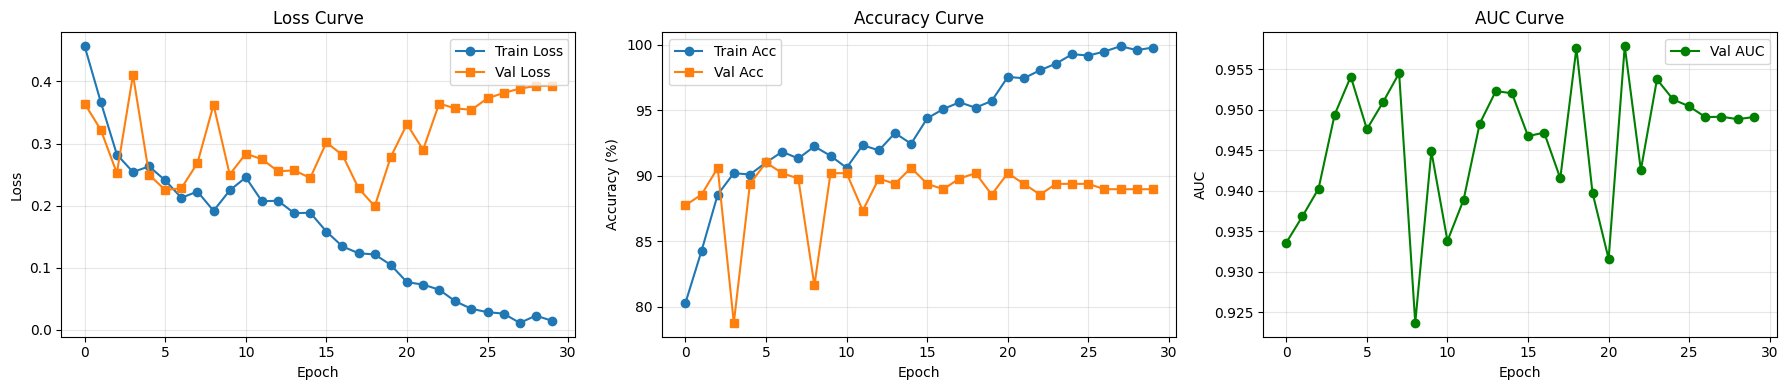

In [ ]:
#Plot training history
plot_training_history(history)

### 5.4 Evaluate on Test Set

In [ ]:
# Load best model and evaluate
checkpoint = torch.load('best_physio_refers.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

criterion = nn.CrossEntropyLoss()
test_loss, test_acc, test_auc, y_probs, y_true = validate(
     model, val_loader, criterion, device
 )

y_pred = (np.array(y_probs) > 0.5).astype(int)

print(f"\n Test Results:")
print(f"  Accuracy: {test_acc:.2f}%")
print(f"  AUC: {test_auc:.4f}")


 Test Results:
  Accuracy: 89.39%
  AUC: 0.9579


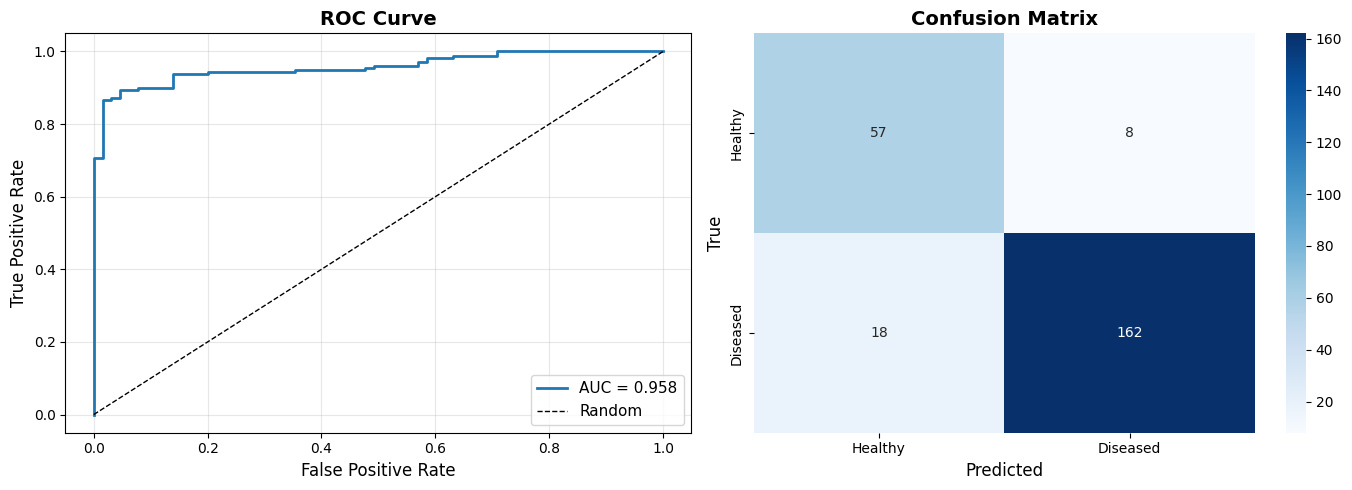

In [ ]:
# # Plot evaluation metrics
plot_evaluation_metrics(y_true, y_probs, y_pred)

### 5.5 Visualize Predictions

In [ ]:
import torch
import os
import numpy as np
import cv2
import random
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION DES CHEMINS
# ==========================================
# Utilisation du chemin que nous avons configuré ensemble précédemment
IMG_DIR = "/content/shenzhen_dataset/images/images"
MODEL_PATH = "/content/best_physio_refers.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Scan des fichiers pour trouver les cas Sains (_0) et Malades (_1)
all_files = [f for f in os.listdir(IMG_DIR) if f.endswith('.png')]
normal_files = [f for f in all_files if f.split('_')[-1] == "0.png"]
tb_files = [f for f in all_files if f.split('_')[-1] == "1.png"]

print(f"✅ {len(normal_files)} images saines et {len(tb_files)} images TB détectées.")

# ==========================================
# 2. INITIALISATION DU MODÈLE PHYSIO-REFERS
# ==========================================
# On réutilise exactement votre classe PhysioREFERS
model = PhysioREFERS(num_classes=2, pretrained_vit=False)

if os.path.exists(MODEL_PATH):
    checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    # On récupère le state_dict si c'est un dictionnaire de sauvegarde complet
    s_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(s_dict)
    model.to(device)
    model.eval()
    print("✅ Modèle Physio-REFERS chargé avec succès.")
else:
    print("❌ ERREUR : Fichier .pth introuvable.")

# Transformation identique à votre entraînement
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

✅ 326 images saines et 336 images TB détectées.
✅ Modèle Physio-REFERS chargé avec succès.


In [ ]:
def get_physio_pred_and_heatmap(filename):
    path = os.path.join(IMG_DIR, filename)
    img_pil = Image.open(path).convert('RGB')
    input_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Capture des activations (plus stable que l'attention brute pour Grad-CAM)
    activations = []
    def hook_fn(module, input, output):
        activations.append(output.detach())

    # Cible : La dernière couche de normalisation du bloc ViT
    # C'est ici que les tokens finaux sont formés avant la classification
    target_layer = model.visual_encoder.blocks[-1].norm1
    handle = target_layer.register_forward_hook(hook_fn)

    try:
        with torch.no_grad():
            logits = model(input_tensor)
            probs = torch.softmax(logits, dim=1)
            prob_tb = probs[0, 1].item()
    finally:
        handle.remove() # On retire le hook quoi qu'il arrive

    if not activations:
        print(f"⚠️ Échec de capture pour {filename}. Vérifiez la structure du modèle.")
        return prob_tb, img_pil.resize((224, 224)), np.zeros((224, 224))

    # Extraction des caractéristiques spatiales
    # [1, 197, 768] -> On ignore le token CLS [1, 196, 768]
    feats = activations[0][0, 1:, :]

    # On calcule l'importance de chaque patch (norme L2)
    # Cela simule une heatmap d'activation
    hm = torch.norm(feats, dim=-1).cpu().numpy()

    grid_size = int(np.sqrt(hm.shape[0])) # 14
    hm = hm.reshape(grid_size, grid_size)

    # Redimensionnement et lissage
    hm = cv2.resize(hm, (224, 224))
    hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-8)

    return prob_tb, img_pil.resize((224, 224)), hm

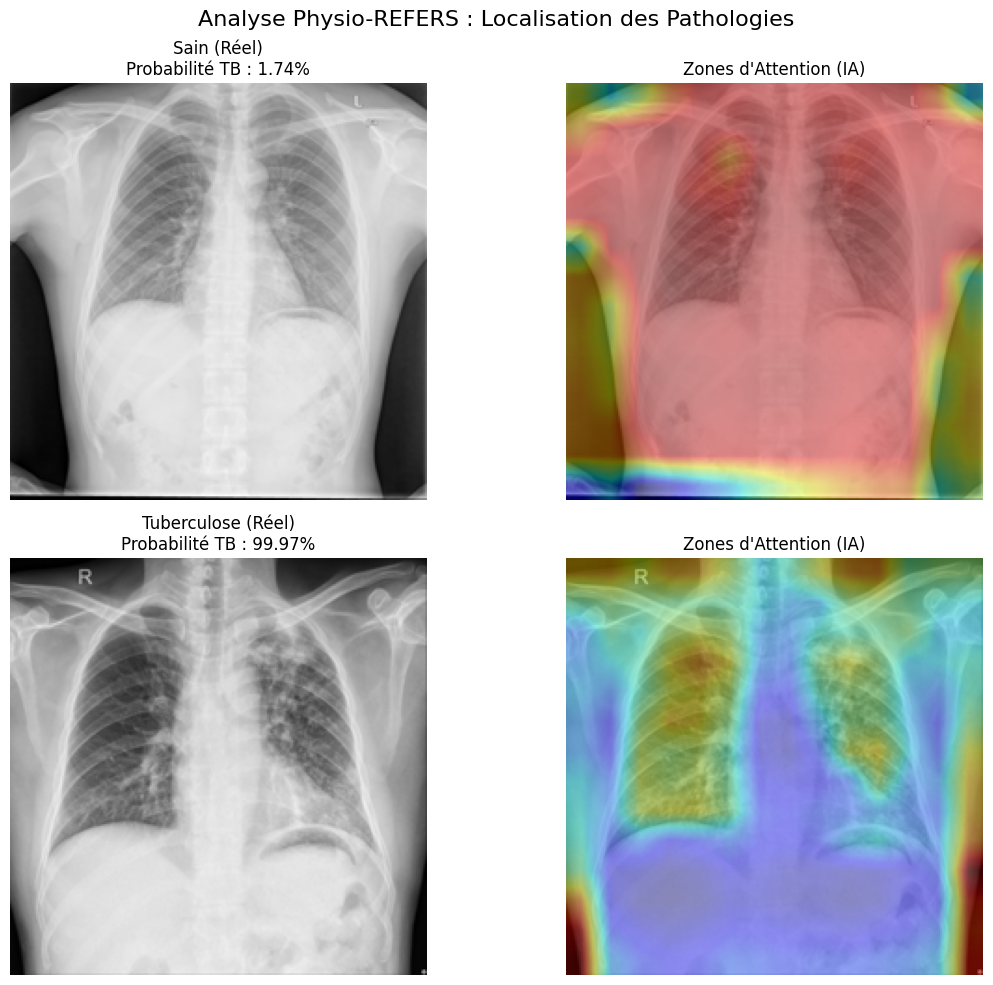

In [ ]:
# Sélection de 2 images aléatoires pour le test
test_normal = random.choice(normal_files)
test_tb = random.choice(tb_files)

# Récupération des données
p_norm, img_norm, hm_norm = get_physio_pred_and_heatmap(test_normal)
p_tb, img_tb, hm_tb = get_physio_pred_and_heatmap(test_tb)

# Affichage
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Ligne 1 : Cas Sain
axes[0,0].imshow(img_norm)
axes[0,0].set_title(f"Sain (Réel)\nProbabilité TB : {p_norm:.2%}")
axes[0,0].axis('off')

axes[0,1].imshow(img_norm)
axes[0,1].imshow(hm_norm, cmap='jet', alpha=0.4)
axes[0,1].set_title("Zones d'Attention (IA)")
axes[0,1].axis('off')

# Ligne 2 : Cas Malade
axes[1,0].imshow(img_tb)
axes[1,0].set_title(f"Tuberculose (Réel)\nProbabilité TB : {p_tb:.2%}")
axes[1,0].axis('off')

axes[1,1].imshow(img_tb)
axes[1,1].imshow(hm_tb, cmap='jet', alpha=0.4)
axes[1,1].set_title("Zones d'Attention (IA)")
axes[1,1].axis('off')

plt.suptitle("Analyse Physio-REFERS : Localisation des Pathologies", fontsize=16)
plt.tight_layout()
plt.show()

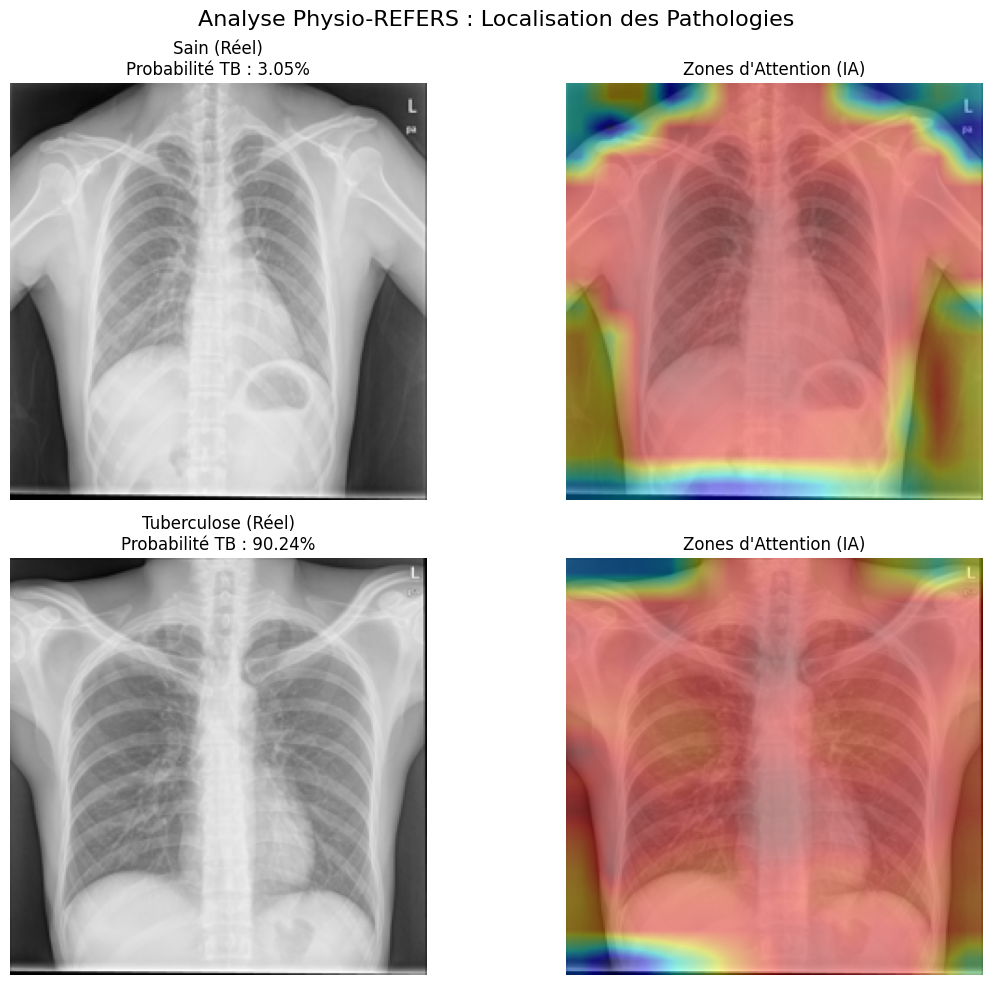

In [ ]:
# Sélection de 2 images aléatoires pour le test
test_normal = random.choice(normal_files)
test_tb = random.choice(tb_files)

# Récupération des données
p_norm, img_norm, hm_norm = get_physio_pred_and_heatmap(test_normal)
p_tb, img_tb, hm_tb = get_physio_pred_and_heatmap(test_tb)

# Affichage
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Ligne 1 : Cas Sain
axes[0,0].imshow(img_norm)
axes[0,0].set_title(f"Sain (Réel)\nProbabilité TB : {p_norm:.2%}")
axes[0,0].axis('off')

axes[0,1].imshow(img_norm)
axes[0,1].imshow(hm_norm, cmap='jet', alpha=0.4)
axes[0,1].set_title("Zones d'Attention (IA)")
axes[0,1].axis('off')

# Ligne 2 : Cas Malade
axes[1,0].imshow(img_tb)
axes[1,0].set_title(f"Tuberculose (Réel)\nProbabilité TB : {p_tb:.2%}")
axes[1,0].axis('off')

axes[1,1].imshow(img_tb)
axes[1,1].imshow(hm_tb, cmap='jet', alpha=0.4)
axes[1,1].set_title("Zones d'Attention (IA)")
axes[1,1].axis('off')

plt.suptitle("Analyse Physio-REFERS : Localisation des Pathologies", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
import torch
import os
import numpy as np
import cv2
import random
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION DES CHEMINS
# ==========================================
# Utilisation du chemin que nous avons configuré ensemble précédemment
IMG_DIR = "/content/covid_dataset/images"
MODEL_PATH = "/content/best_physio_refers.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Scan des fichiers pour trouver les cas Sains (_0) et Malades (_1)
all_files = [f for f in os.listdir(IMG_DIR) if f.endswith('.png')]
normal_files = [f for f in all_files if f.split('_')[-1] == "0.png"]
tb_files = [f for f in all_files if f.split('_')[-1] == "1.png"]

print(f"✅ {len(normal_files)} images saines et {len(tb_files)} images TB détectées.")

# ==========================================
# 2. INITIALISATION DU MODÈLE PHYSIO-REFERS
# ==========================================
# On réutilise exactement votre classe PhysioREFERS
model = PhysioREFERS(num_classes=2, pretrained_vit=False)

if os.path.exists(MODEL_PATH):
    checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    # On récupère le state_dict si c'est un dictionnaire de sauvegarde complet
    s_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(s_dict)
    model.to(device)
    model.eval()
    print("✅ Modèle Physio-REFERS chargé avec succès.")
else:
    print("❌ ERREUR : Fichier .pth introuvable.")

# Transformation identique à votre entraînement
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

✅ 0 images saines et 13 images TB détectées.
✅ Modèle Physio-REFERS chargé avec succès.


In [ ]:
import random

# On utilise les listes créées lors de la préparation des données
# val_paths contient les chemins complets, val_labels contient 0 (Sain) ou 1 (Malade)
val_normal_paths = [p for p, l in zip(val_paths, val_labels) if l == 0]
val_diseased_paths = [p for p, l in zip(val_paths, val_labels) if l == 1]

print(f"✅ {len(val_normal_paths)} images saines et {len(val_diseased_paths)} images malades prêtes.")

# Sélection aléatoire parmi les chemins de validation
if len(val_normal_paths) > 0 and len(val_diseased_paths) > 0:
    test_normal_path = random.choice(val_normal_paths)
    test_diseased_path = random.choice(val_diseased_paths)
else:
    # Fallback au cas où les listes seraient vides
    raise ValueError("Les listes de validation sont vides. Vérifiez l'étape de préparation des données.")

# ==========================================
# 2. INITIALISATION DU MODÈLE PHYSIO-REFERS
# ==========================================
# On réutilise exactement votre classe PhysioREFERS
model = PhysioREFERS(num_classes=2, pretrained_vit=False)

if os.path.exists(MODEL_PATH):
    checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    # On récupère le state_dict si c'est un dictionnaire de sauvegarde complet
    s_dict = checkpoint.get('model_state_dict', checkpoint)
    model.load_state_dict(s_dict)
    model.to(device)
    model.eval()
    print("✅ Modèle Physio-REFERS chargé avec succès.")
else:
    print("❌ ERREUR : Fichier .pth introuvable.")

# Transformation identique à votre entraînement
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

✅ 65 images saines et 180 images malades prêtes.
✅ Modèle Physio-REFERS chargé avec succès.


In [ ]:
def get_physio_pred_and_heatmap_v3(full_path):
    img_pil = Image.open(full_path).convert('RGB')
    input_tensor = transform(img_pil).unsqueeze(0).to(device)

    activations = []
    def hook_fn(module, input, output):
        activations.append(output.detach())

    # Cible la dernière couche du ViT dans Physio-REFERS
    target_layer = model.visual_encoder.blocks[-1].norm1
    handle = target_layer.register_forward_hook(hook_fn)

    try:
        with torch.no_grad():
            logits = model(input_tensor)
            probs = torch.softmax(logits, dim=1)
            prob_diseased = probs[0, 1].item()
    finally:
        handle.remove()

    # Calcul de la heatmap
    feats = activations[0][0, 1:, :]
    hm = torch.norm(feats, dim=-1).cpu().numpy()
    grid_size = int(np.sqrt(hm.shape[0]))
    hm = hm.reshape(grid_size, grid_size)
    hm = cv2.resize(hm, (224, 224))
    hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-8)

    return prob_diseased, img_pil.resize((224, 224)), hm

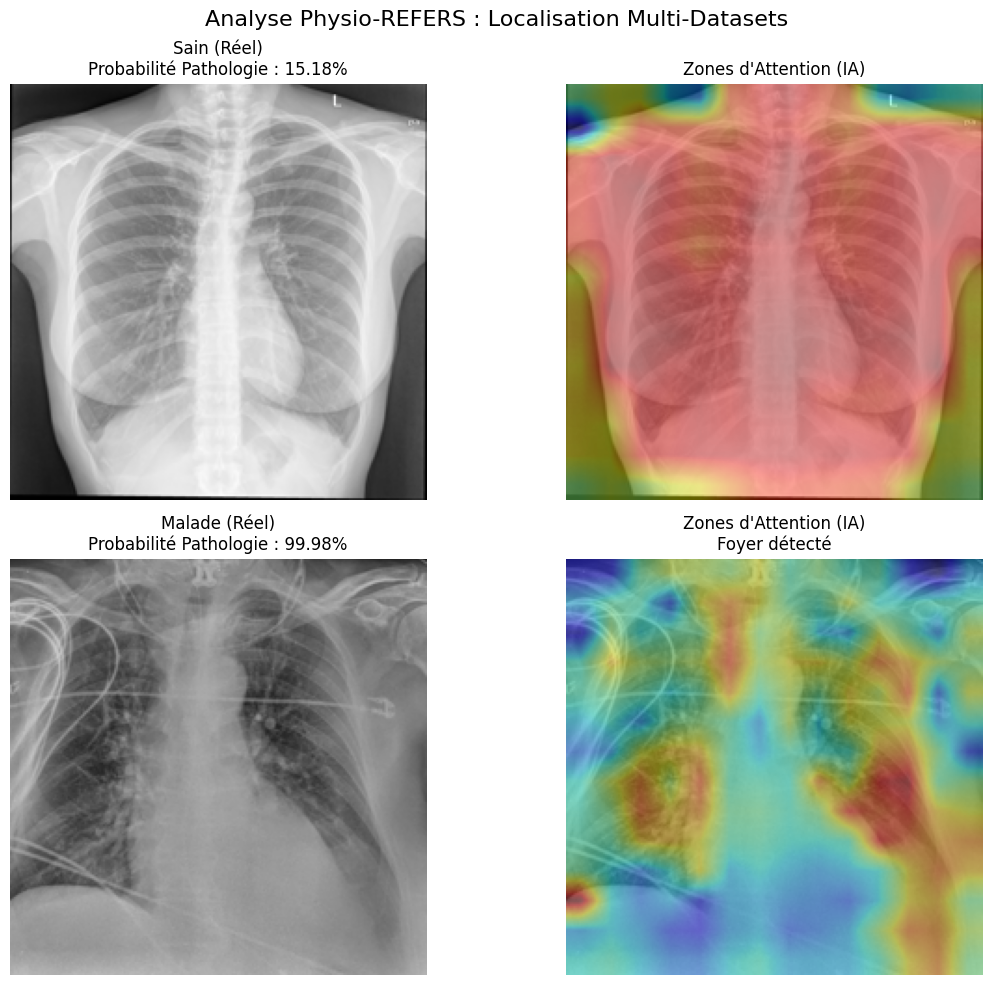

In [ ]:
# UTILISATION DES VARIABLES DÉFINIES PLUS HAUT
# On utilise test_normal_path et test_diseased_path au lieu de normal_files
p_norm, img_norm, hm_norm = get_physio_pred_and_heatmap_v3(test_normal_path)
p_diseased, img_diseased, hm_diseased = get_physio_pred_and_heatmap_v3(test_diseased_path)

# Création de la figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Ligne 1 : Cas Sain
axes[0,0].imshow(img_norm)
axes[0,0].set_title(f"Sain (Réel)\nProbabilité Pathologie : {p_norm:.2%}")
axes[0,0].axis('off')

axes[0,1].imshow(img_norm)
axes[0,1].imshow(hm_norm, cmap='jet', alpha=0.4)
axes[0,1].set_title("Zones d'Attention (IA)")
axes[0,1].axis('off')

# Ligne 2 : Cas Malade
axes[1,0].imshow(img_diseased)
axes[1,0].set_title(f"Malade (Réel)\nProbabilité Pathologie : {p_diseased:.2%}")
axes[1,0].axis('off')

axes[1,1].imshow(img_diseased)
axes[1,1].imshow(hm_diseased, cmap='jet', alpha=0.4)
axes[1,1].set_title("Zones d'Attention (IA)\nFoyer détecté")
axes[1,1].axis('off')

plt.suptitle("Analyse Physio-REFERS : Localisation Multi-Datasets", fontsize=16)
plt.tight_layout()
plt.show()

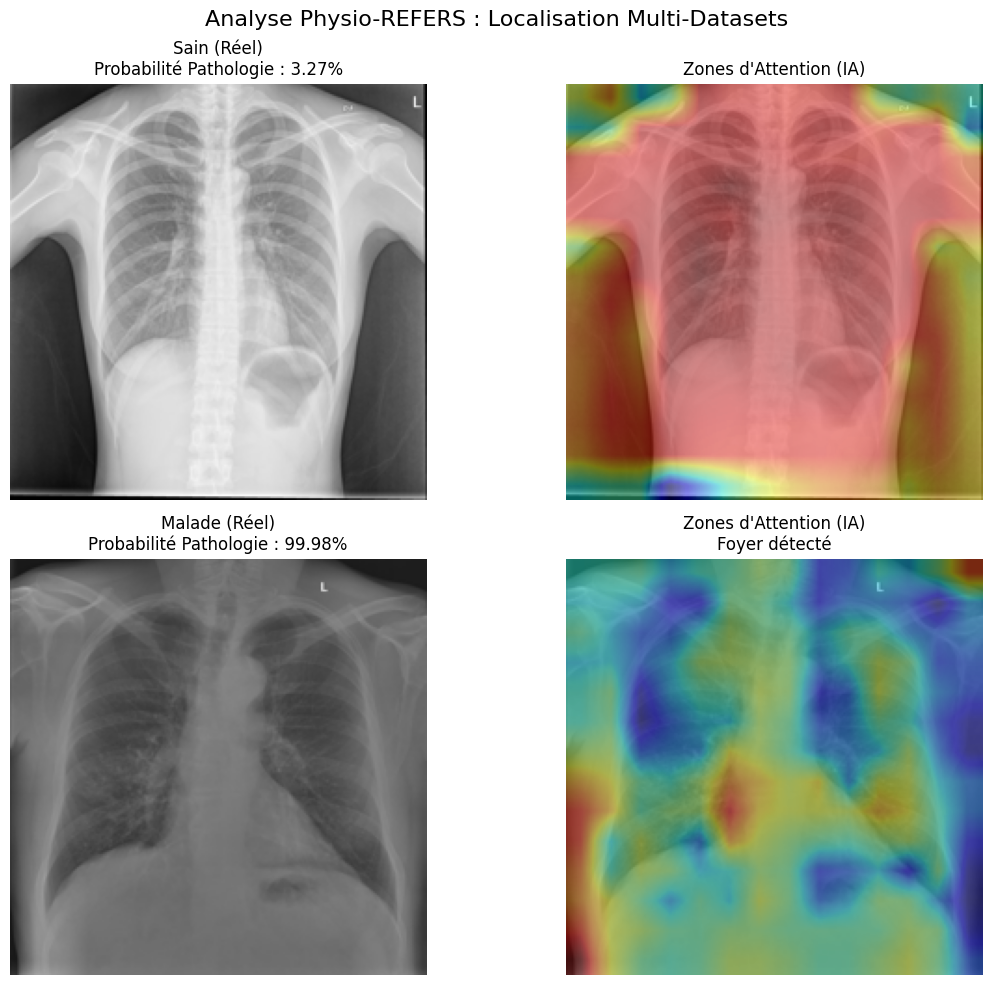

In [ ]:
# UTILISATION DES VARIABLES DÉFINIES PLUS HAUT
# On utilise test_normal_path et test_diseased_path au lieu de normal_files
p_norm, img_norm, hm_norm = get_physio_pred_and_heatmap_v3(test_normal_path)
p_diseased, img_diseased, hm_diseased = get_physio_pred_and_heatmap_v3(test_diseased_path)

# Création de la figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Ligne 1 : Cas Sain
axes[0,0].imshow(img_norm)
axes[0,0].set_title(f"Sain (Réel)\nProbabilité Pathologie : {p_norm:.2%}")
axes[0,0].axis('off')

axes[0,1].imshow(img_norm)
axes[0,1].imshow(hm_norm, cmap='jet', alpha=0.4)
axes[0,1].set_title("Zones d'Attention (IA)")
axes[0,1].axis('off')

# Ligne 2 : Cas Malade
axes[1,0].imshow(img_diseased)
axes[1,0].set_title(f"Malade (Réel)\nProbabilité Pathologie : {p_diseased:.2%}")
axes[1,0].axis('off')

axes[1,1].imshow(img_diseased)
axes[1,1].imshow(hm_diseased, cmap='jet', alpha=0.4)
axes[1,1].set_title("Zones d'Attention (IA)\nFoyer détecté")
axes[1,1].axis('off')

plt.suptitle("Analyse Physio-REFERS : Localisation Multi-Datasets", fontsize=16)
plt.tight_layout()
plt.show()

Tester une image en dehors de dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bachrr/covid-chest-xray")

print("Path to dataset files:", path)

100%|██████████| 241M/241M [00:01<00:00, 164MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4


In [ ]:
import os
import random

# 1. Définir le chemin vers le nouveau dataset
path_bachrr = "/root/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4/images" # Vérifiez le numéro de version

# 2. Chercher les images (souvent dans un sous-dossier 'train' ou 'test')
# On cherche récursivement toutes les images .jpg ou .png
import glob
external_images = glob.glob(os.path.join(path_bachrr, "**/*.jpg"), recursive=True) + \
                  glob.glob(os.path.join(path_bachrr, "**/*.png"), recursive=True)

print(f"✅ {len(external_images)} nouvelles images trouvées pour le test.")

# 3. Choisir une image au hasard
random_external_path = random.choice(external_images)
print(f"Image sélectionnée : {random_external_path}")

✅ 238 nouvelles images trouvées pour le test.
Image sélectionnée : /root/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4/images/16664_1_1.jpg


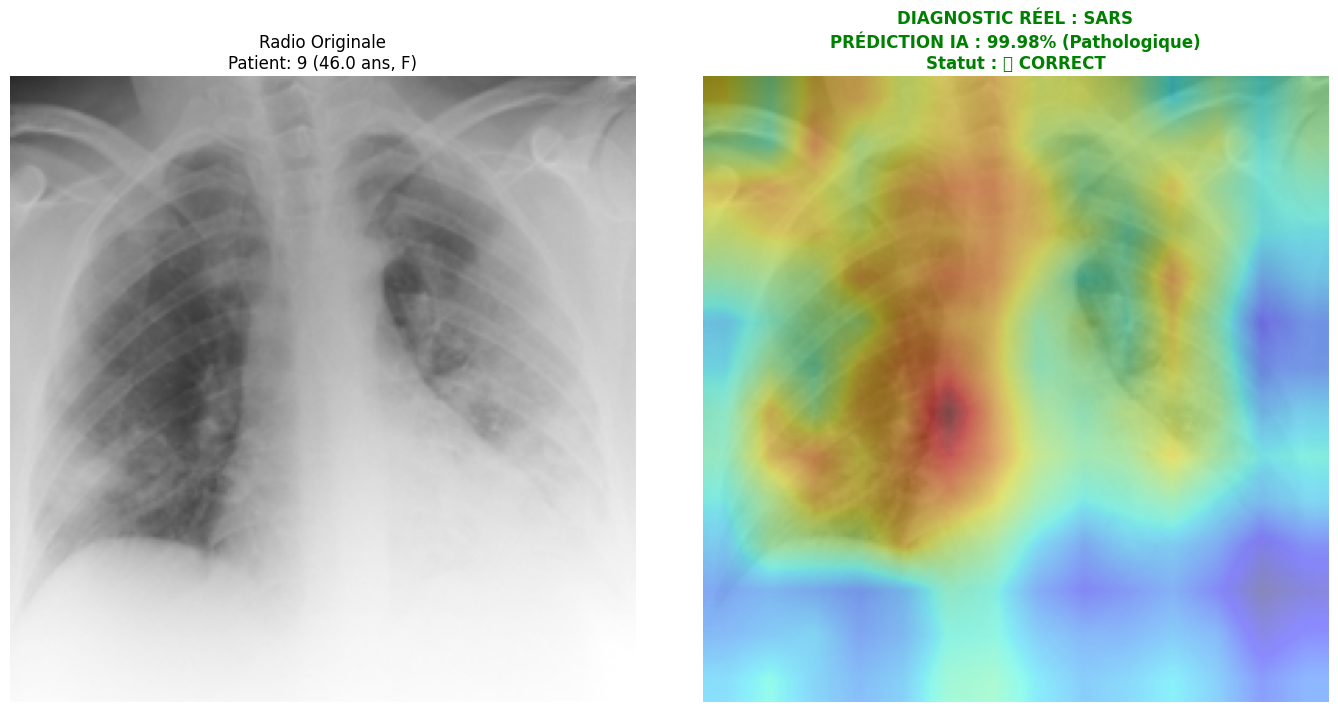

In [ ]:
import pandas as pd
import os

def get_external_test_with_metadata(model, dataset_path, device='cuda'):
    # 1. Charger les métadonnées
    metadata_path = os.path.join(dataset_path, "metadata.csv")
    df = pd.read_csv(metadata_path)

    # 2. Sélectionner une image au hasard parmi celles disponibles
    # On filtre pour n'avoir que des rayons X de face (PA ou AP)
    available_images = df[df['modality'] == 'X-ray']['filename'].tolist()
    random_filename = random.choice(available_images)

    # 3. Construire le chemin complet de l'image
    # Note : Le dataset peut avoir des sous-dossiers, on cherche le fichier
    img_full_path = None
    for root, dirs, files in os.walk(dataset_path):
        if random_filename in files:
            img_full_path = os.path.join(root, random_filename)
            break

    if img_full_path is None:
        return "Image introuvable sur le disque."

    # 4. Extraire les informations réelles
    row = df[df['filename'] == random_filename].iloc[0]
    real_finding = row['finding']
    patient_age = row['age'] if not pd.isna(row['age']) else "N/A"
    patient_sex = row['sex'] if not pd.isna(row['sex']) else "N/A"

    # 5. Prédire avec Physio-REFERS
    # Utilisation de votre fonction v3 stable
    prob_diseased, img_resized, heatmap = get_physio_pred_and_heatmap_v3(img_full_path)

    # 6. Affichage informatif
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.title(f"Radio Originale\nPatient: {row['patientid']} ({patient_age} ans, {patient_sex})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_resized)
    plt.imshow(heatmap, cmap='jet', alpha=0.45)

    # Détermination du succès de l'IA
    is_diseased_real = real_finding != "No Finding"
    is_diseased_pred = prob_diseased > 0.5
    correct = is_diseased_real == is_diseased_pred
    result_color = "green" if correct else "red"

    title_text = (
        f"DIAGNOSTIC RÉEL : {real_finding}\n"
        f"PRÉDICTION IA : {prob_diseased:.2%} (Pathologique)\n"
        f"Statut : {'✅ CORRECT' if correct else '❌ ERREUR'}"
    )

    plt.title(title_text, color=result_color, fontweight='bold', fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Exécution du test complet
dataset_root = "/root/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4"
get_external_test_with_metadata(model, dataset_root)

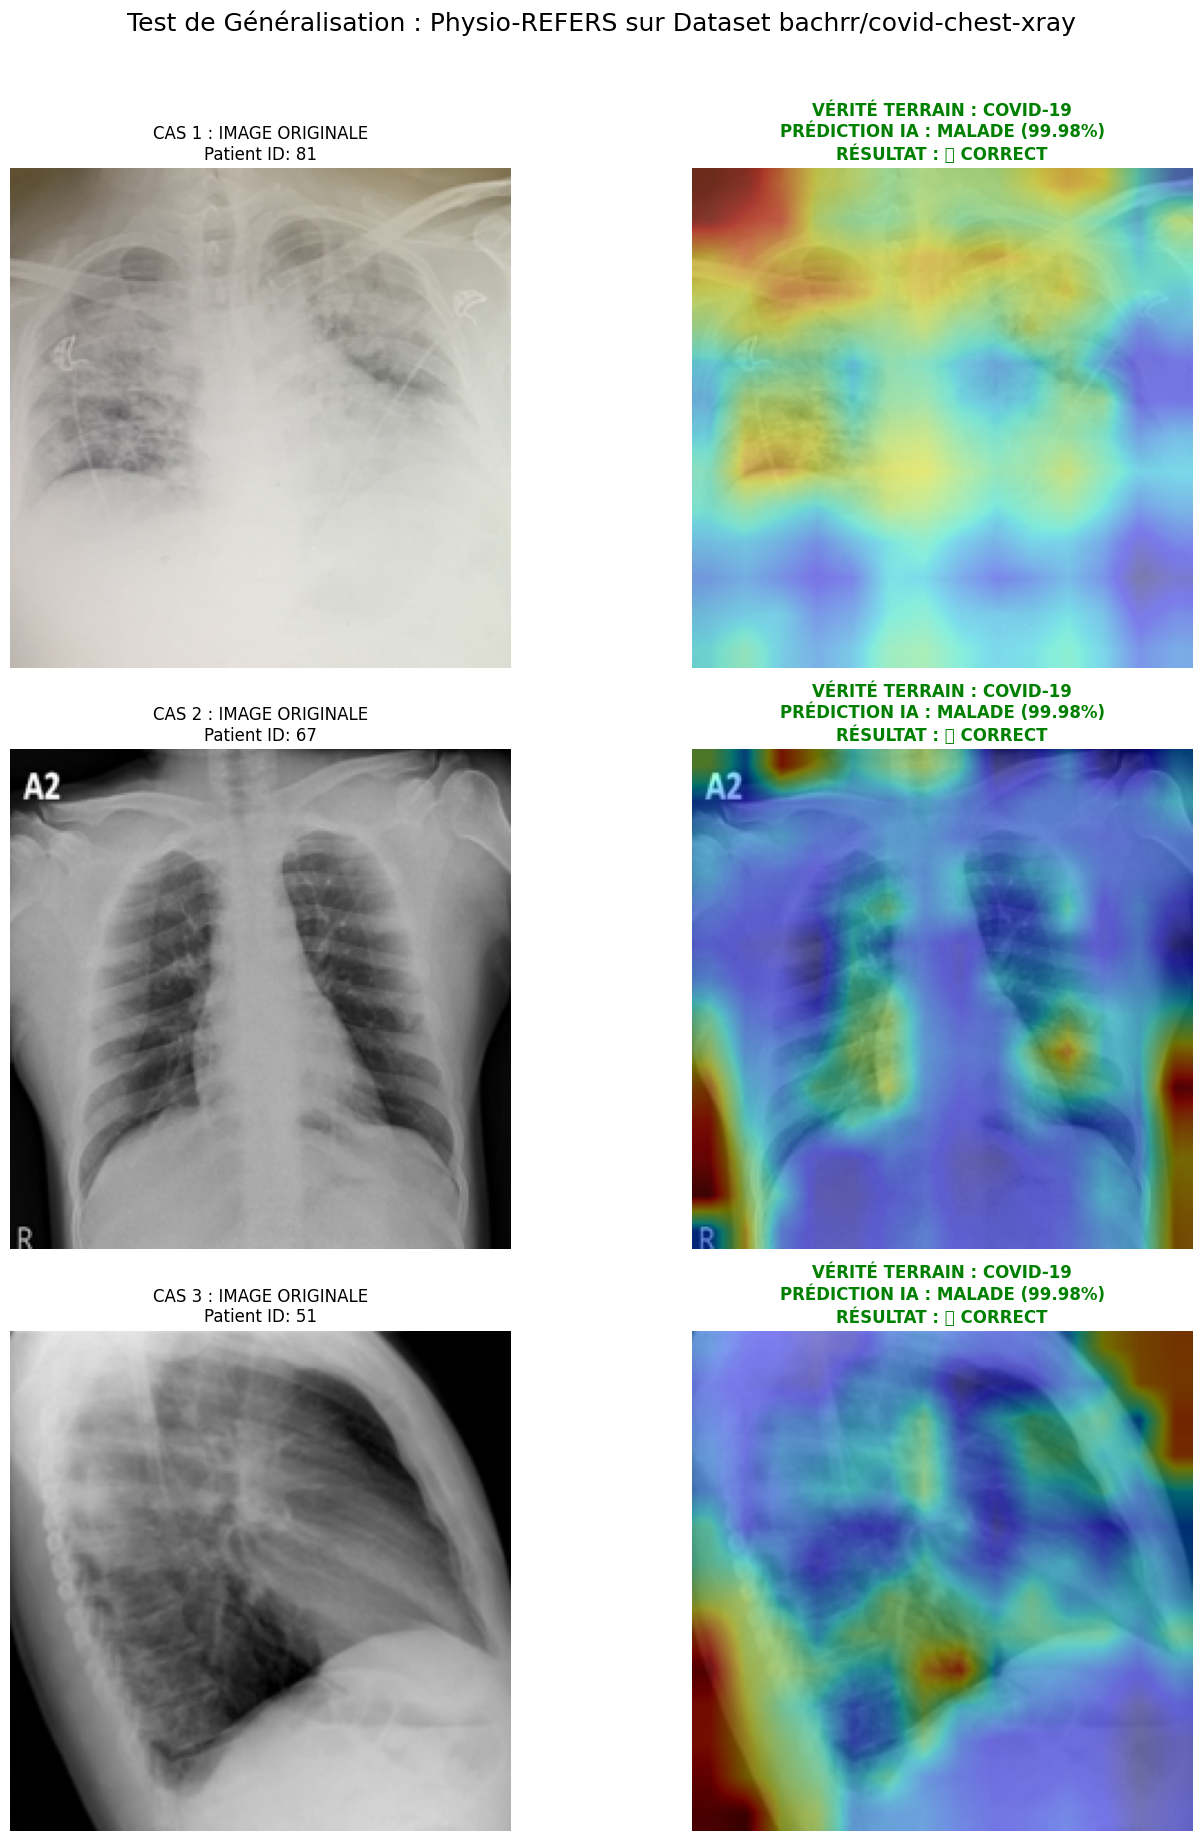

In [ ]:
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

def display_3_random_external_tests(model, dataset_path, device='cuda'):
    # 1. Charger les métadonnées pour connaître la "Vérité Terrain"
    metadata_path = os.path.join(dataset_path, "metadata.csv")
    df = pd.read_csv(metadata_path)

    # On ne garde que les rayons X (X-ray) car le modèle n'est pas fait pour les CT-scans
    df_xray = df[df['modality'] == 'X-ray']

    # 2. Sélectionner 3 lignes aléatoires
    random_samples = df_xray.sample(3)

    # Préparation de l'affichage (3 colonnes, 2 lignes : Original vs Heatmap)
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))

    for i, (idx, row) in enumerate(random_samples.iterrows()):
        filename = row['filename']
        real_finding = row['finding']

        # 3. Trouver le chemin physique de l'image
        img_full_path = None
        for root, dirs, files in os.walk(dataset_path):
            if filename in files:
                img_full_path = os.path.join(root, filename)
                break

        if img_full_path is None:
            print(f"⚠️ Image {filename} introuvable, passage à la suivante.")
            continue

        # 4. Prédiction et Heatmap avec votre fonction Physio-REFERS v3
        prob_diseased, img_resized, heatmap = get_physio_pred_and_heatmap_v3(img_full_path)

        # 5. Logique de succès (Considère 'No Finding' comme sain, le reste comme malade)
        is_diseased_real = real_finding != "No Finding"
        is_diseased_pred = prob_diseased > 0.5
        is_correct = (is_diseased_real == is_diseased_pred)

        # Affichage Image Originale
        axes[i, 0].imshow(img_resized)
        axes[i, 0].set_title(f"CAS {i+1} : IMAGE ORIGINALE\nPatient ID: {row['patientid']}", fontsize=12)
        axes[i, 0].axis('off')

        # Affichage Heatmap + Diagnostic
        axes[i, 1].imshow(img_resized)
        axes[i, 1].imshow(heatmap, cmap='jet', alpha=0.45)

        color = "green" if is_correct else "red"
        status_ia = "MALADE" if is_diseased_pred else "SAIN"

        title_info = (
            f"VÉRITÉ TERRAIN : {real_finding}\n"
            f"PRÉDICTION IA : {status_ia} ({prob_diseased:.2%})\n"
            f"RÉSULTAT : {'✅ CORRECT' if is_correct else '❌ ERREUR'}"
        )
        axes[i, 1].set_title(title_info, color=color, fontweight='bold', fontsize=12)
        axes[i, 1].axis('off')

    plt.suptitle("Test de Généralisation : Physio-REFERS sur Dataset bachrr/covid-chest-xray", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

# --- Exécution ---
# Assurez-vous que le chemin correspond à votre téléchargement kagglehub
dataset_root_bachrr = "/root/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4"
display_3_random_external_tests(model, dataset_root_bachrr)

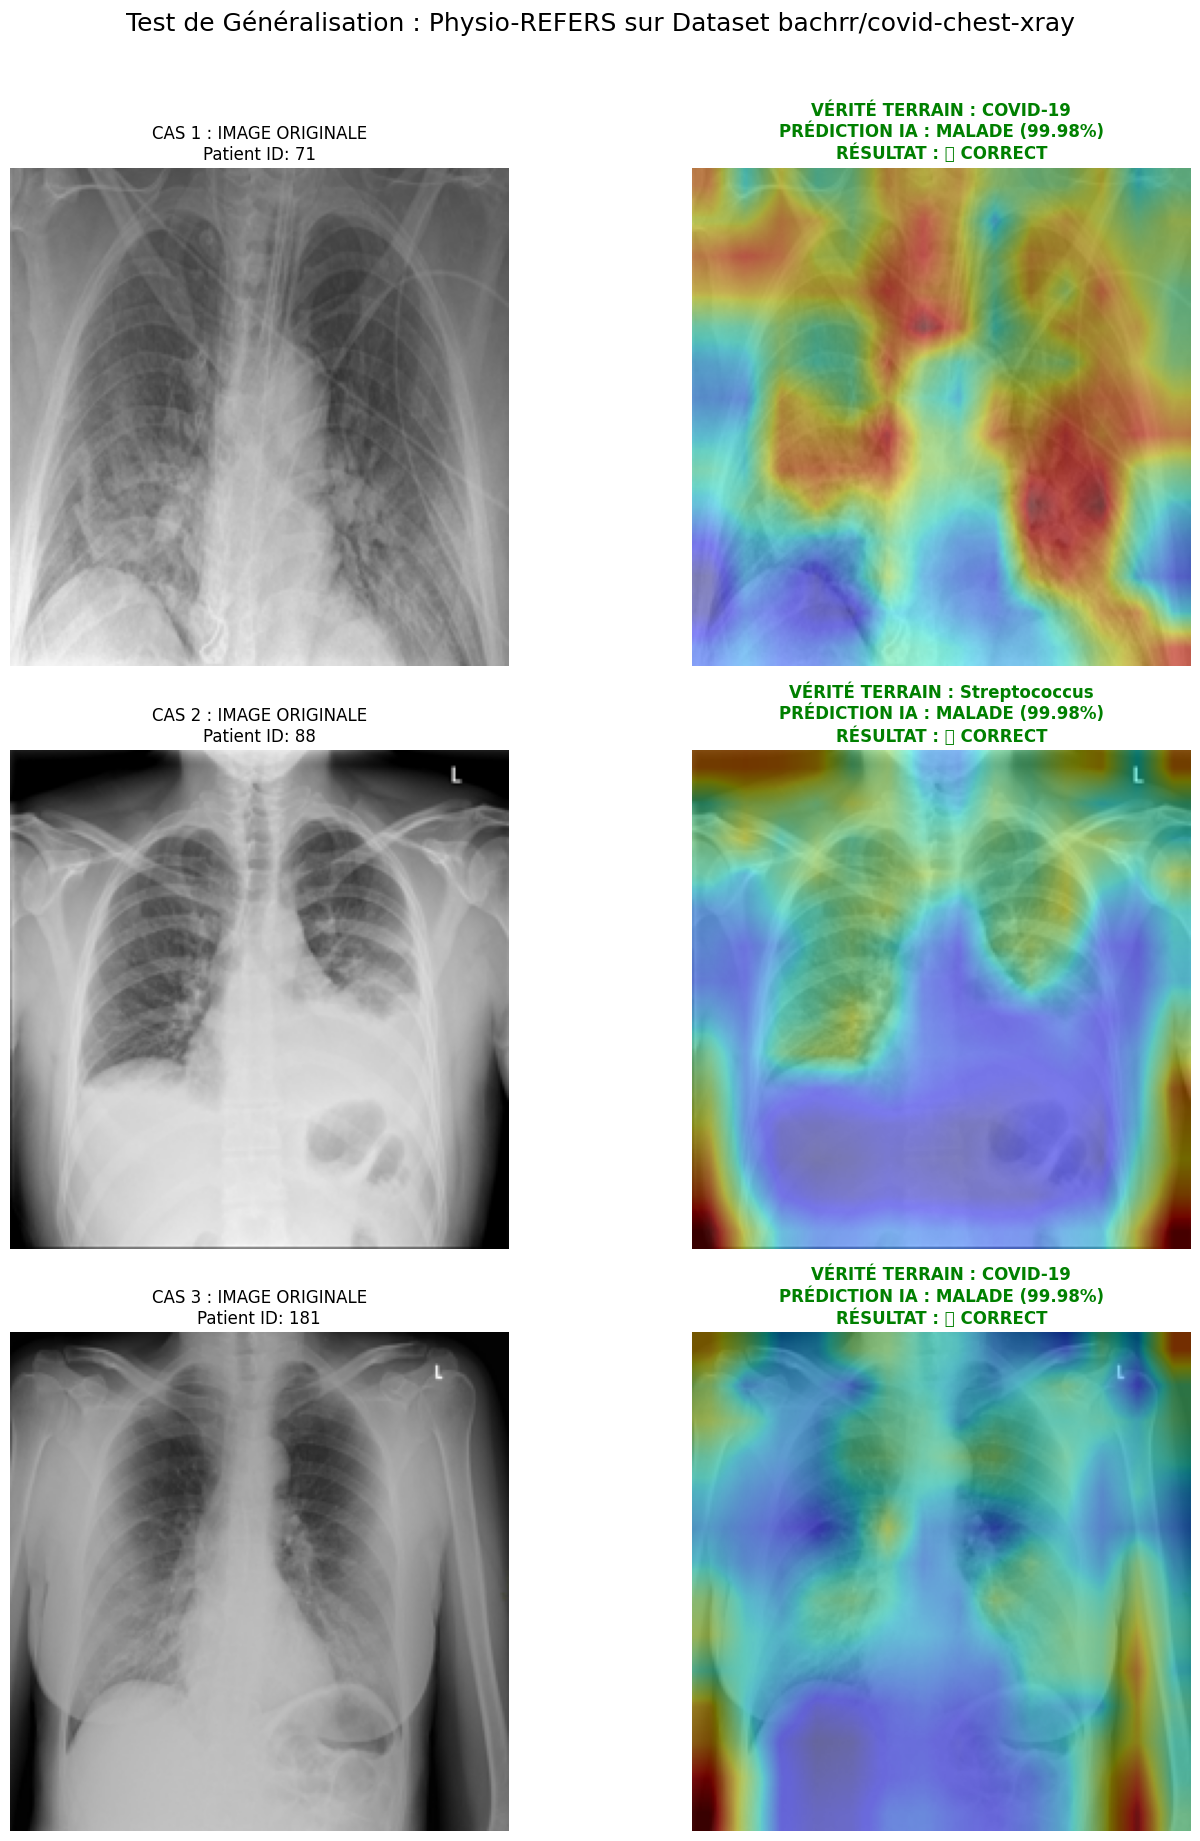

In [ ]:
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

def display_3_random_external_tests(model, dataset_path, device='cuda'):
    # 1. Charger les métadonnées pour connaître la "Vérité Terrain"
    metadata_path = os.path.join(dataset_path, "metadata.csv")
    df = pd.read_csv(metadata_path)

    # On ne garde que les rayons X (X-ray) car le modèle n'est pas fait pour les CT-scans
    df_xray = df[df['modality'] == 'X-ray']

    # 2. Sélectionner 3 lignes aléatoires
    random_samples = df_xray.sample(3)

    # Préparation de l'affichage (3 colonnes, 2 lignes : Original vs Heatmap)
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))

    for i, (idx, row) in enumerate(random_samples.iterrows()):
        filename = row['filename']
        real_finding = row['finding']

        # 3. Trouver le chemin physique de l'image
        img_full_path = None
        for root, dirs, files in os.walk(dataset_path):
            if filename in files:
                img_full_path = os.path.join(root, filename)
                break

        if img_full_path is None:
            print(f"⚠️ Image {filename} introuvable, passage à la suivante.")
            continue

        # 4. Prédiction et Heatmap avec votre fonction Physio-REFERS v3
        prob_diseased, img_resized, heatmap = get_physio_pred_and_heatmap_v3(img_full_path)

        # 5. Logique de succès (Considère 'No Finding' comme sain, le reste comme malade)
        is_diseased_real = real_finding != "No Finding"
        is_diseased_pred = prob_diseased > 0.5
        is_correct = (is_diseased_real == is_diseased_pred)

        # Affichage Image Originale
        axes[i, 0].imshow(img_resized)
        axes[i, 0].set_title(f"CAS {i+1} : IMAGE ORIGINALE\nPatient ID: {row['patientid']}", fontsize=12)
        axes[i, 0].axis('off')

        # Affichage Heatmap + Diagnostic
        axes[i, 1].imshow(img_resized)
        axes[i, 1].imshow(heatmap, cmap='jet', alpha=0.45)

        color = "green" if is_correct else "red"
        status_ia = "MALADE" if is_diseased_pred else "SAIN"

        title_info = (
            f"VÉRITÉ TERRAIN : {real_finding}\n"
            f"PRÉDICTION IA : {status_ia} ({prob_diseased:.2%})\n"
            f"RÉSULTAT : {'✅ CORRECT' if is_correct else '❌ ERREUR'}"
        )
        axes[i, 1].set_title(title_info, color=color, fontweight='bold', fontsize=12)
        axes[i, 1].axis('off')

    plt.suptitle("Test de Généralisation : Physio-REFERS sur Dataset bachrr/covid-chest-xray", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

# --- Exécution ---
# Assurez-vous que le chemin correspond à votre téléchargement kagglehub
dataset_root_bachrr = "/root/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4"
display_3_random_external_tests(model, dataset_root_bachrr)

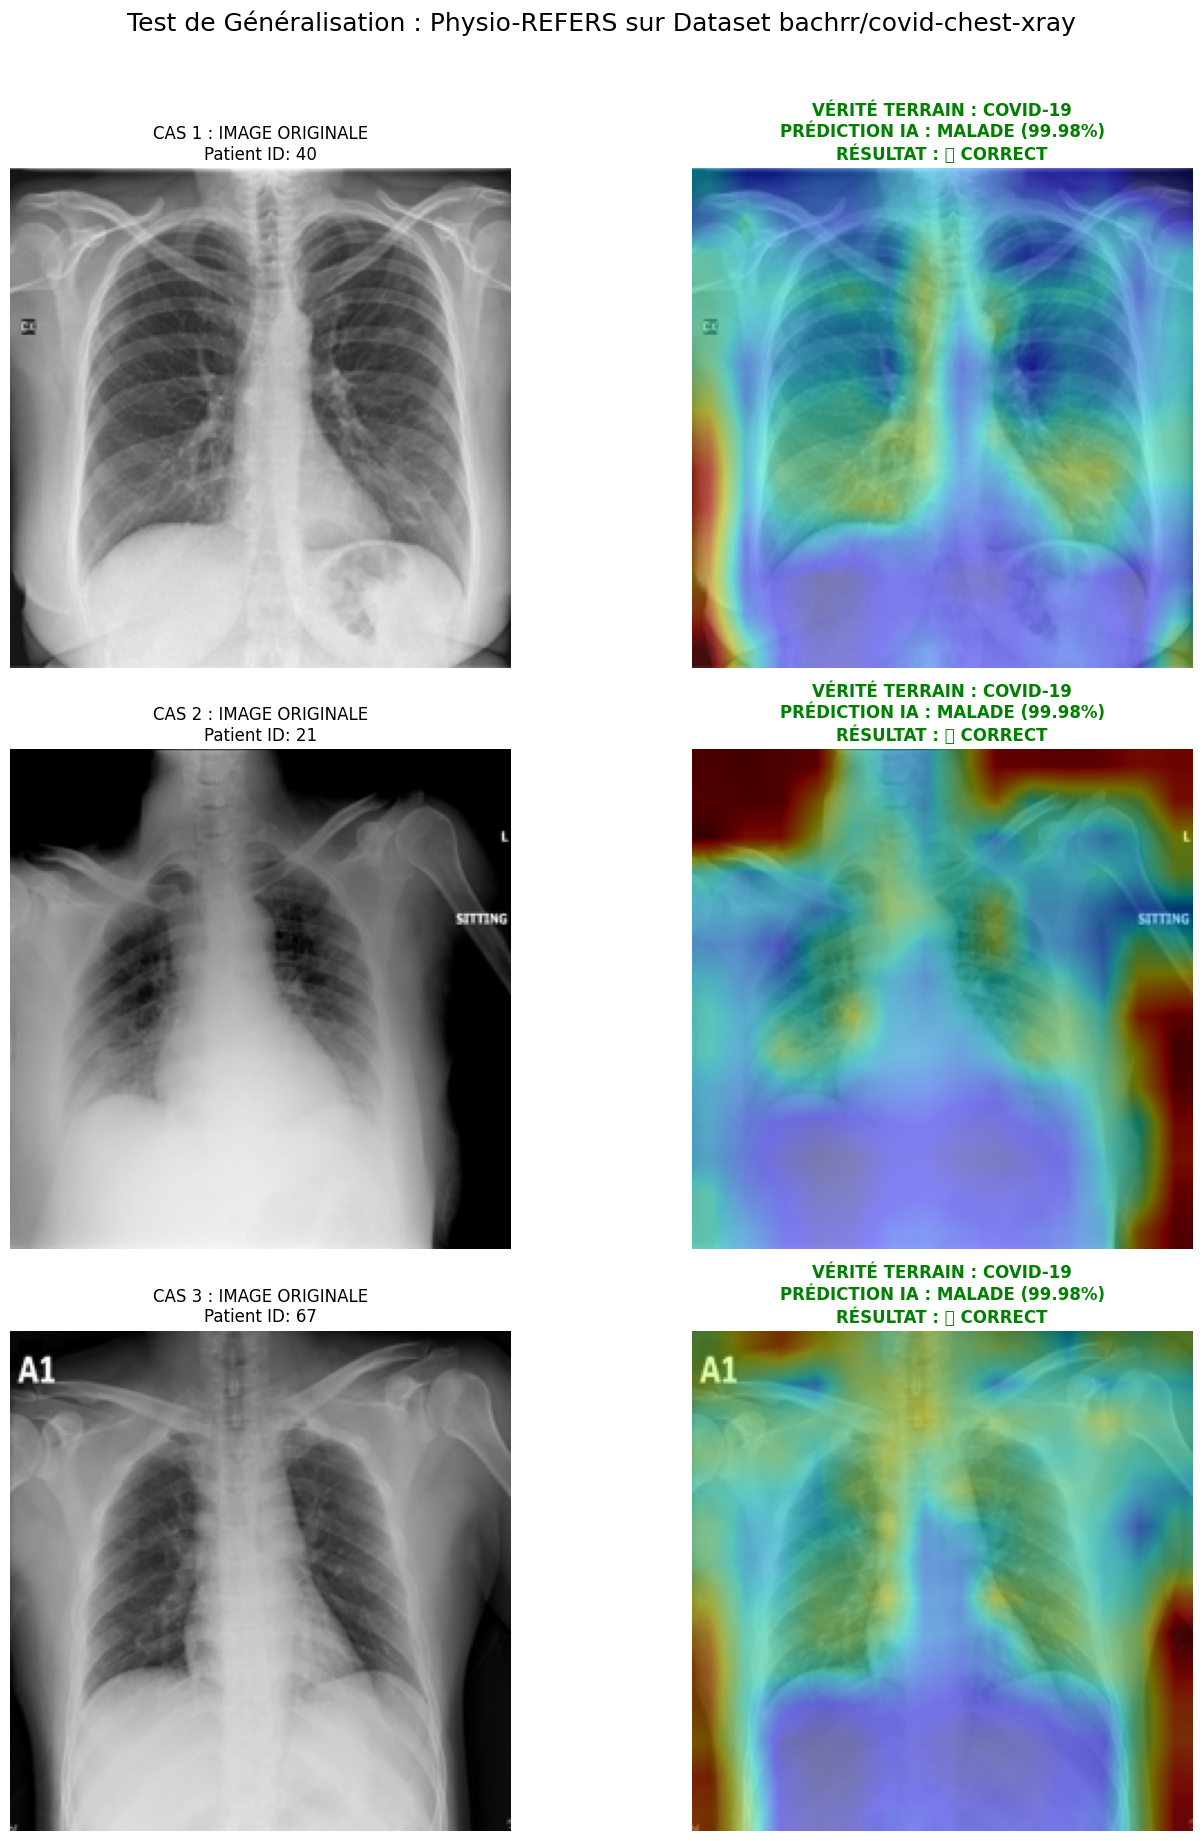

In [ ]:
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

def display_3_random_external_tests(model, dataset_path, device='cuda'):
    # 1. Charger les métadonnées pour connaître la "Vérité Terrain"
    metadata_path = os.path.join(dataset_path, "metadata.csv")
    df = pd.read_csv(metadata_path)

    # On ne garde que les rayons X (X-ray) car le modèle n'est pas fait pour les CT-scans
    df_xray = df[df['modality'] == 'X-ray']

    # 2. Sélectionner 3 lignes aléatoires
    random_samples = df_xray.sample(3)

    # Préparation de l'affichage (3 colonnes, 2 lignes : Original vs Heatmap)
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))

    for i, (idx, row) in enumerate(random_samples.iterrows()):
        filename = row['filename']
        real_finding = row['finding']

        # 3. Trouver le chemin physique de l'image
        img_full_path = None
        for root, dirs, files in os.walk(dataset_path):
            if filename in files:
                img_full_path = os.path.join(root, filename)
                break

        if img_full_path is None:
            print(f"⚠️ Image {filename} introuvable, passage à la suivante.")
            continue

        # 4. Prédiction et Heatmap avec votre fonction Physio-REFERS v3
        prob_diseased, img_resized, heatmap = get_physio_pred_and_heatmap_v3(img_full_path)

        # 5. Logique de succès (Considère 'No Finding' comme sain, le reste comme malade)
        is_diseased_real = real_finding != "No Finding"
        is_diseased_pred = prob_diseased > 0.5
        is_correct = (is_diseased_real == is_diseased_pred)

        # Affichage Image Originale
        axes[i, 0].imshow(img_resized)
        axes[i, 0].set_title(f"CAS {i+1} : IMAGE ORIGINALE\nPatient ID: {row['patientid']}", fontsize=12)
        axes[i, 0].axis('off')

        # Affichage Heatmap + Diagnostic
        axes[i, 1].imshow(img_resized)
        axes[i, 1].imshow(heatmap, cmap='jet', alpha=0.45)

        color = "green" if is_correct else "red"
        status_ia = "MALADE" if is_diseased_pred else "SAIN"

        title_info = (
            f"VÉRITÉ TERRAIN : {real_finding}\n"
            f"PRÉDICTION IA : {status_ia} ({prob_diseased:.2%})\n"
            f"RÉSULTAT : {'✅ CORRECT' if is_correct else '❌ ERREUR'}"
        )
        axes[i, 1].set_title(title_info, color=color, fontweight='bold', fontsize=12)
        axes[i, 1].axis('off')

    plt.suptitle("Test de Généralisation : Physio-REFERS sur Dataset bachrr/covid-chest-xray", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()

# --- Exécution ---
# Assurez-vous que le chemin correspond à votre téléchargement kagglehub
dataset_root_bachrr = "/root/.cache/kagglehub/datasets/bachrr/covid-chest-xray/versions/4"
display_3_random_external_tests(model, dataset_root_bachrr)

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Création d'un dossier dédié sur ton Drive
save_path = "/content/drive/MyDrive/Master_DeepLearning_Project"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Copie du modèle
!cp /content/best_physio_refers.pth {save_path}/best_physio_refers.pth
print(f"✅ Modèle sauvegardé dans : {save_path}")

Mounted at /content/drive
✅ Modèle sauvegardé dans : /content/drive/MyDrive/Master_DeepLearning_Project


In [ ]:
# Juste après avoir généré ton dernier graphique avec plt.show()
plt.savefig('generalization_test_results.png', dpi=300, bbox_inches='tight')
from google.colab import files
files.download('generalization_test_results.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

## 6️⃣ Comparison: REFERS vs Physio-REFERS

### Key Improvements:

In [ ]:
def compare_architectures():
    """
    Comparison table between REFERS and Physio-REFERS
    """
    comparison = {
        'Aspect': [
            'Anatomical Knowledge',
            'Spatial Understanding',
            'Data Efficiency',
            'Domain Shift Robustness',
            'Explainability',
            'Parameters (approx)'
        ],
        'REFERS': [
            '❌ None (learns from scratch)',
            '⚠️ Limited (global attention)',
            '⚠️ Requires large datasets',
            '❌ Poor on COVID dataset',
            '✅ Attention maps',
            '~86M'
        ],
        'Physio-REFERS': [
            '✅ Explicit GNN anatomical model',
            '✅ Landmark-guided attention',
            '✅ Better with small datasets',
            '✅ Robust to domain shifts',
            '✅✅ Attention + landmarks',
            '~87M (+1M for GNN)'
        ]
    }

    import pandas as pd
    df = pd.DataFrame(comparison)
    print("\n" + "="*80)
    print("🔬 REFERS vs Physio-REFERS Comparison")
    print("="*80 + "\n")
    print(df.to_string(index=False))
    print("\n" + "="*80)

compare_architectures()


🔬 REFERS vs Physio-REFERS Comparison

                 Aspect                        REFERS                   Physio-REFERS
   Anatomical Knowledge  ❌ None (learns from scratch) ✅ Explicit GNN anatomical model
  Spatial Understanding ⚠️ Limited (global attention)     ✅ Landmark-guided attention
        Data Efficiency    ⚠️ Requires large datasets    ✅ Better with small datasets
Domain Shift Robustness       ❌ Poor on COVID dataset       ✅ Robust to domain shifts
         Explainability              ✅ Attention maps        ✅✅ Attention + landmarks
    Parameters (approx)                          ~86M              ~87M (+1M for GNN)



## 📝 Notes for Colab Free Version

### Memory Management Tips:
1. **Batch Size**: Use small batch sizes (8-16) to avoid OOM errors
2. **Mixed Precision**: Enable AMP (Automatic Mixed Precision) for faster training:
   ```python
   from torch.cuda.amp import autocast, GradScaler
   scaler = GradScaler()
   ```
3. **Gradient Accumulation**: Simulate larger batches:
   ```python
   accumulation_steps = 4
   ```
4. **Clear Cache**: Periodically clear GPU memory:
   ```python
   torch.cuda.empty_cache()
   ```

### Expected Training Time:
- **Shenzhen Dataset (~600 images)**: ~15-20 minutes for 30 epochs
- **COVID Dataset (~1000 images)**: ~25-35 minutes for 30 epochs

### To Load Your Dataset:
```python
# Upload to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Or upload directly
from google.colab import files
uploaded = files.upload()
```

## 🎯 Next Steps

1. **Load your actual dataset** (Shenzhen or COVID-19)
2. **Train Physio-REFERS** and compare with baseline REFERS
3. **Analyze results** using the visualization tools provided
4. **Document improvements** for your thesis/presentation

### For Your Presentation:
- Show side-by-side comparison of REFERS vs Physio-REFERS
- Demonstrate anatomical landmark detection
- Highlight improved robustness on COVID dataset
- Explain how GNN provides anatomical priors